In [73]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
plt.rcParams.update({'font.size': 14})

from copy import deepcopy
import argparse
import os
import linsolve

from hera_cal import utils
from hera_cal import version
from hera_cal.noise import predict_noise_variance_from_autos
from hera_cal.datacontainer import DataContainer
from hera_cal.utils import split_pol, conj_pol, split_bl, reverse_bl, join_bl, join_pol, comply_pol
from hera_cal.io import HERAData, HERACal, write_cal, save_redcal_meta
from hera_cal.apply_cal import calibrate_in_place

## Importing functions
from hera_cal.redcal import _get_pol_load_list, filter_reds, redundantly_calibrate, expand_omni_sol,get_pos_reds ,add_pol_reds
import All_functions as logical ## Logi_Cal functions
import modified_redcal

### Fixing degenaracies


import hera_pspec as hp
import hera_cal as hc
from hera_sim import io

## Classification
from sklearn.cluster import KMeans

# import uvtools
# import hera_cal as hc
# import hera_pspec as hp
# from pyuvdata import UVCal, UVData
# import pyuvdata.utils as uvutils




SEC_PER_DAY = 86400.
IDEALIZED_BL_TOL = 1e-8  # bl_error_tol for redcal.get_reds when using antenna positions calculated from reds


In [3]:
# filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.calfits"## Gain file


##########################################################################################################################
##########################################################################################################################


# calib_param = "10_10_60"  ## Array_nfreq_ntimes

non_red_cases_list = ["case3a", "case_4a_0.01", "case_4b_0.01", "case_5"]
non_red_case = non_red_cases_list[0]

calib_param = "75_120_10"  ## Array_nfreq_ntimes

## ========================================================= Case 3a =================================================================
filename = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01_g_cal.uvh5"  ## Calibrated Data
filename1 = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01_g.uvh5"     ## Uncalibrated data
filename2 = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01.uvh5"       ## True data
gain_filename = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01.calfits"## Gain file

# ## ========================================================= Case 4a_0.01 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01.calfits"## Gain file


# ## ========================================================= Case 4b_0.01 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01.calfits"## Gain file


# ## ========================================================= Case 5 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_5//calibration_" +calib_param+ "/viscatBC_5_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5.calfits"## Gain file


#############################################################################################################################################

# filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"
# gain_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.calfits"## Gain file


# filename = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01.uvh5"
# gain_filename = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01.calfits"  ## Gain file




c_data = HERAData(filename)   ## calibrated data
c_data.read()

hd = HERAData(filename1)   ## Uncalibrated data (data has noise and gains)
hd.read()

true_data = HERAData(filename2)  ## True data (No noise and gains)
true_data.read()


import utils

true_gains, _= hc.io.load_cal(gain_filename)  ## Calling dictionary of true gains

from hera_cal import utils


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


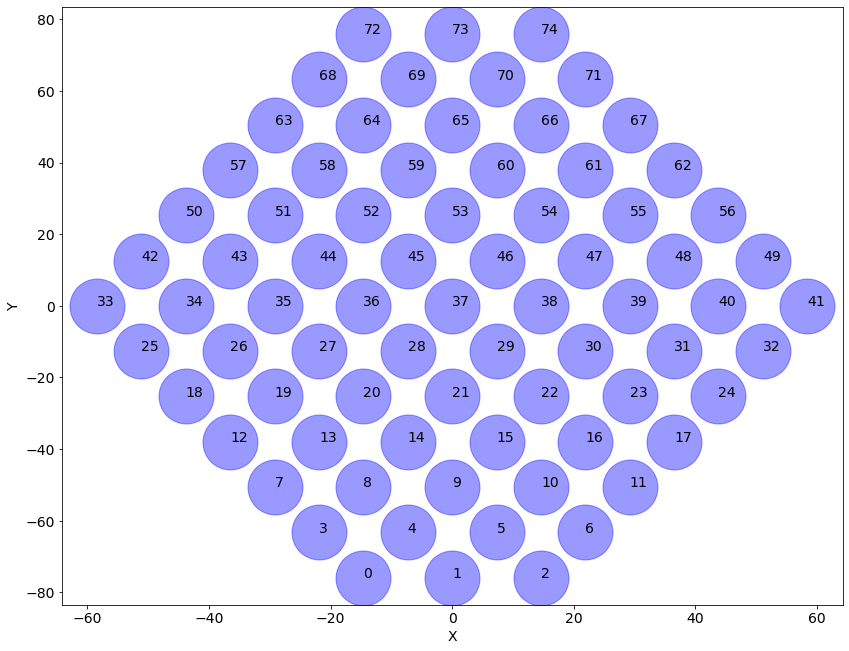

In [4]:
plt.figure(figsize=(14,11))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1],'bo', alpha=0.4, label='0', markersize=55)
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Running Red_Cal

In [5]:
from hera_cal.redcal import redcal_iteration

# Running RedCal
red_gains = redcal_iteration(hd)

## Fixing degeneracies

red_gains_fixed = logical.fix_redcal_degeneracies(filename1, red_gains['g_omnical'],true_gains)

Telescope hera_sim is not in known_telescopes.


## Using modified_redcal.py to call Logi_cal

In [6]:
#### Using a k-means clustering

N_red_clusters = 30
k_value = 4
#Running Logi_Cal 

customized_groups = modified_redcal.get_custom_reds(hd,c_data,k_value,N_red_clusters)
custom_red_gains = modified_redcal.redcal_iteration_custom2(hd,customized_groups)


## Fixing degeneracies

custom_red_gains_fixed = logical.fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)



redcal_iteration_custom2 Complete


Telescope hera_sim is not in known_telescopes.


## Using All_functions.py to call Logi_cal

In [8]:
#### Using a k-means clustering

N_red_clusters = 4
k_value = 3
#Running Logi_Cal 
customized_groups = logical.custom_reds2(hd,c_data,k_value,N_red_clusters)
custom_red_gains = logical.redcal_iteration_custom2(hd,customized_groups,max_bl_cut=None)


## Fixing degeneracies
custom_red_gains_fixed = logical.fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)



redcal_iteration_custom2 Complete


Telescope hera_sim is not in known_telescopes.


## Using All_functions_mod.py to call Logi_cal with max_bl_cut included

In [118]:
from hera_cal.redcal import redcal_iteration

# Running RedCal
red_gains = redcal_iteration(hd,max_bl_cut=None)

## Fixing degeneracies

red_gains_fixed = logical.fix_redcal_degeneracies(filename1, red_gains['g_omnical'],true_gains)

Telescope hera_sim is not in known_telescopes.


In [109]:
N_red_clusters = 60
k_value = 4
#Running Logi_Cal 
customized_groups = logical.custom_reds2(hd,c_data,k_value,N_red_clusters)

In [119]:
#### Using a k-means clustering

# N_red_clusters = 35
# k_value = 4
# #Running Logi_Cal 
# customized_groups = logical.custom_reds2(hd,c_data,k_value,N_red_clusters)
custom_red_gains = logical.redcal_iteration_custom2(hd,customized_groups,max_bl_cut=None)


## Fixing degeneracies
custom_red_gains_fixed = logical.fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)



redcal_iteration_custom2 Complete


In [7]:
X_custom_true_sum  = logical.calulate_X2_sum(true_gains,red_gains_fixed, custom_red_gains_fixed)[1]
X_red_true_sum  = logical.calulate_X2_sum(true_gains,red_gains_fixed, custom_red_gains_fixed )[0]

np.shape(X_custom_true_sum[0])

()

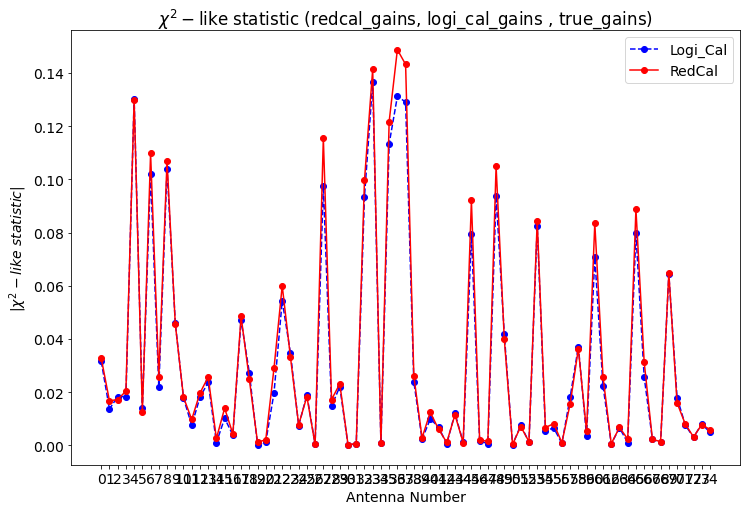

In [9]:
## Alternate between plots using "abs", "real" and "imag"

y_values = X_custom_true_sum
x_values = np.arange(len(y_values))

plt.figure(figsize=(12,8))

plt.plot(np.abs(X_custom_true_sum),'bo--', label='Logi_Cal')
plt.plot(np.abs(X_red_true_sum),'ro-', label='RedCal')
plt.xlabel('Antenna Number')
plt.ylabel('|$\chi^2-like~ statistic$|')
#plt.title('custom_red_gains_fixed vs red_gains_fixed')

positions = np.arange(len(y_values))
labels = x_values
plt.xticks(positions, labels)
plt.title('$\chi^2-$like statistic (redcal_gains, logi_cal_gains , true_gains)')
plt.legend()

#plt.savefig('../plots/Testing_logi-cal/gains/chi2_0red_groups_10array.jpeg')
plt.show()

Number of antennas with improved gains =  57


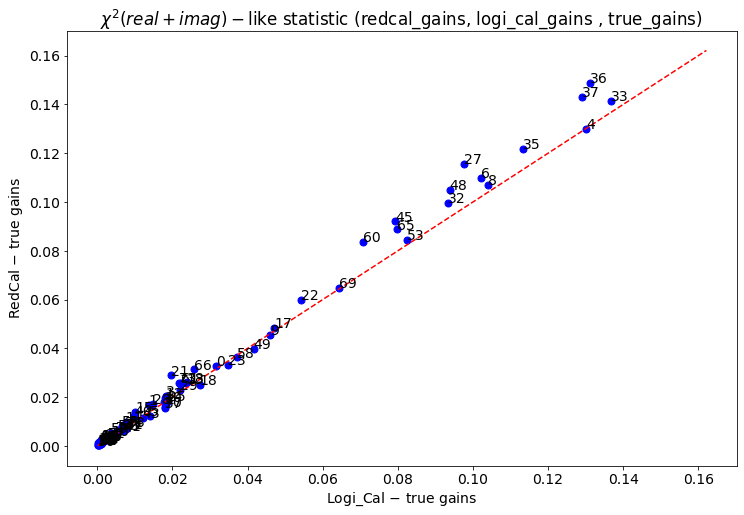

In [10]:
# x_values = np.real(X_custom_true)  ## Logi_Cal
# y_values = np.real(X_red_true)    ## RedCal

# x_values = np.imag(X_custom_true)  ## Logi_Cal
# y_values = np.imag(X_red_true)    ## RedCal

# x_values = np.abs(X_custom_true)  ## Logi_Cal
# y_values = np.abs(X_red_true)    ## RedCal

x_values = np.array(X_custom_true_sum)  ## Logi_Cal
y_values = np.array(X_red_true_sum)   ## RedCal


fit_line = np.linspace(np.min(x_values), np.max(y_values)+(0.09*np.max(y_values)), len(x_values))

# fit_line = np.linspace(np.min(x_values), np.max(x_values), len(x_values))


len_true = x_values<y_values
true_count = sum(len_true)


print("Number of antennas with improved gains = ", true_count)
plt.figure(figsize=(12,8))
for i in range(len(y_values)):
    plt.plot(x_values[i], y_values[i], 'bo', markersize=7)
    plt.annotate('{}'.format(i), (x_values[i], y_values[i]) )


plt.plot(fit_line,fit_line, 'r--')
# plt.plot(np.unique(x_values), np.poly1d(np.polyfit(x_values, y_values, 1))(np.unique(x_values)))
plt.xlabel('Logi_Cal $-$ true gains')
plt.ylabel('RedCal $-$ true gains')
# plt.title('$\chi^2 (Real)-$like statistic (redcal_gains, logi_cal_gains , true_gains) ')
plt.title('$\chi^2 (real+imag)-$like statistic (redcal_gains, logi_cal_gains , true_gains) ')

# plt.savefig('../non-redundant-pipeline/test_simulations/plots/_' +non_red_case+'_'+calib_param + '_({})_3-2__({}).jpeg'.format(N_red_clusters, true_count))
# plt.savefig('../plots/Testing_logi-cal/random_clustering/_' +non_red_case+'_'+calib_param + '_({})_{}-3__({}).jpeg'.format(N_red_clusters,custom_groups[1] , true_count))

plt.show()




## Results
#### HERA-75, [nfreq, ntimes] = [120 , 10] , 
- RBGs = 30, k-value=4, Max_bl_cut = 100  , Antennas with improved gains= [54 ,56 ]
- RBGs = 30, k-value=4, Max_bl_cut = 80  , Antennas with improved gains= [61, 60]
- RBGs = 35, k-value=4, Max_bl_cut = 80  , Antennas with improved gains= 60

- RBGs = 30, k-value=3, Max_bl_cut = 80  , Antennas with improved gains= 54
- RBGs = 30, k-value=4, Max_bl_cut = 60  , Antennas with improved gains= [50, 48]
- RBGs = 30, k-value=4, Max_bl_cut = 60  , Antennas with improved gains= 44
- RBGs = 35, k-value=4, Max_bl_cut = 40  , Antennas with improved gains= 46
- RBGs = 60, k-value=4, Max_bl_cut = 80  , Antennas with improved gains= 53
- RBGs = 60, k-value=4, Max_bl_cut = None  , Antennas with improved gains= 57

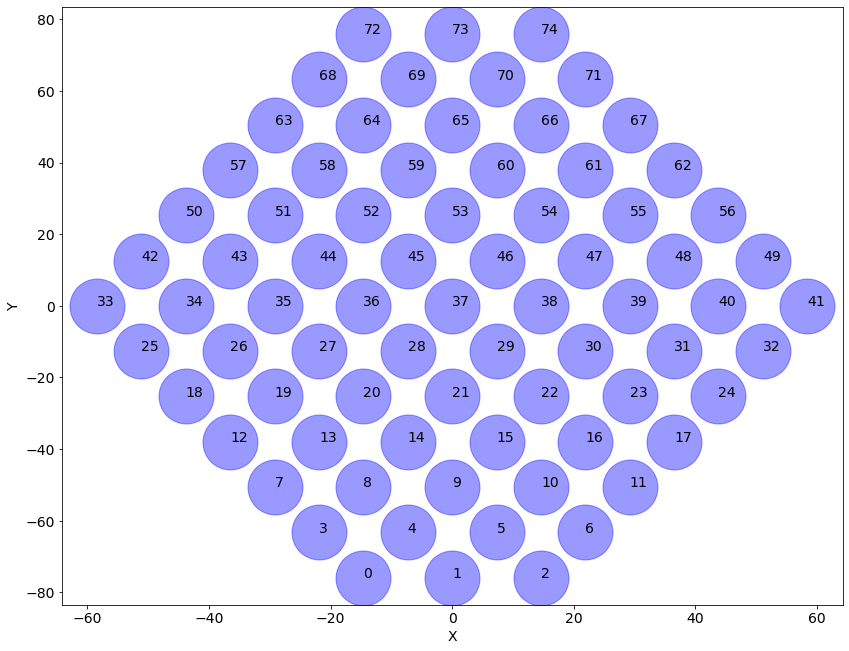

In [12]:
plt.figure(figsize=(14,11))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1],'bo', alpha=0.4, label='0', markersize=55)
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

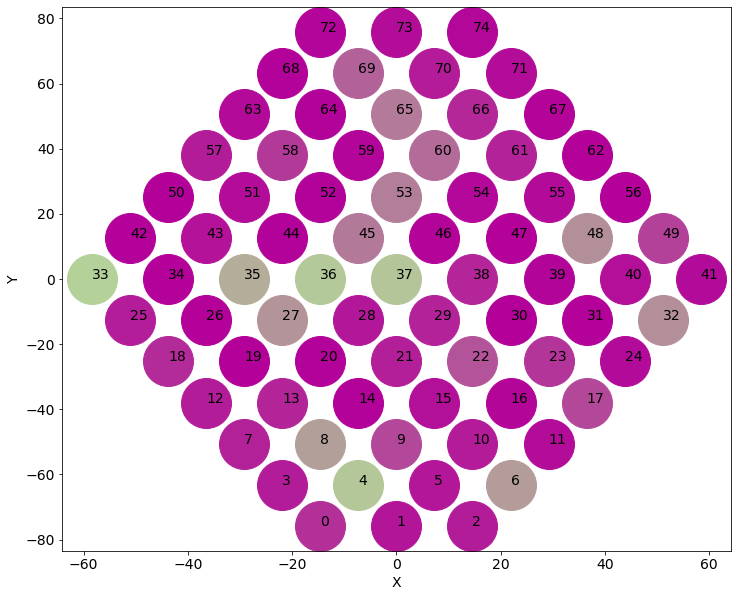

In [63]:
plt.figure(figsize=(12,10))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1], color=(0.7, (6*x_values[i]), 0.6),marker='o', markersize=50)

#     plt.scatter(hd.antpos[i][0], hd.antpos[i][1], color='red', alpha=(6*x_values[i]),marker='o')
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

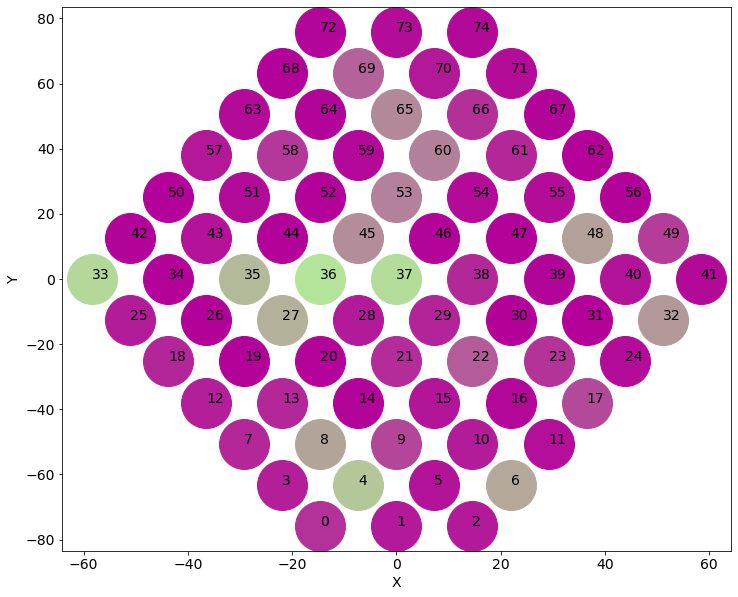

In [72]:
plt.figure(figsize=(12,10))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1], color=(0.7, (6*y_values[i]), 0.6),marker='o', markersize=50)

#     plt.scatter(hd.antpos[i][0], hd.antpos[i][1], color='red', alpha=(6*x_values[i]),marker='o')
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [184]:
from hera_cal import io
from matplotlib import pyplot as plt
%matplotlib inline



(data, flags, antpos, ants, freqs, times, lsts, pols) = io.load_vis(hd, return_meta=True)

bad_ants = [  0  , 2 , 15 , 63 ,70]

In [74]:


# plt.figure(figsize=(6,5), dpi=100)

# plt.scatter(np.array(list(antpos.values()))[:,0], np.array(list(antpos.values()))[:,1],
#             c=[ant in bad_ants for ant in antpos.keys()], s=400, cmap='jet')
# for ant,pos in antpos.items():
#     plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
# plt.xlabel("East-West [meters]", fontsize=14)
# plt.ylabel("North-South [meters]", fontsize=14)
# plt.title('Antenna Positions on 2458098 (Red = Flagged)');
# plt.axis('equal')
# plt.tight_layout()



In [202]:
ant

74